In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d usmanafzaal/strawberry-disease-detection-dataset
!unzip -q /content/strawberry-disease-detection-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset
License(s): unknown
100% 532M/534M [00:24<00:00, 20.9MB/s]
100% 534M/534M [00:24<00:00, 22.4MB/s]


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━

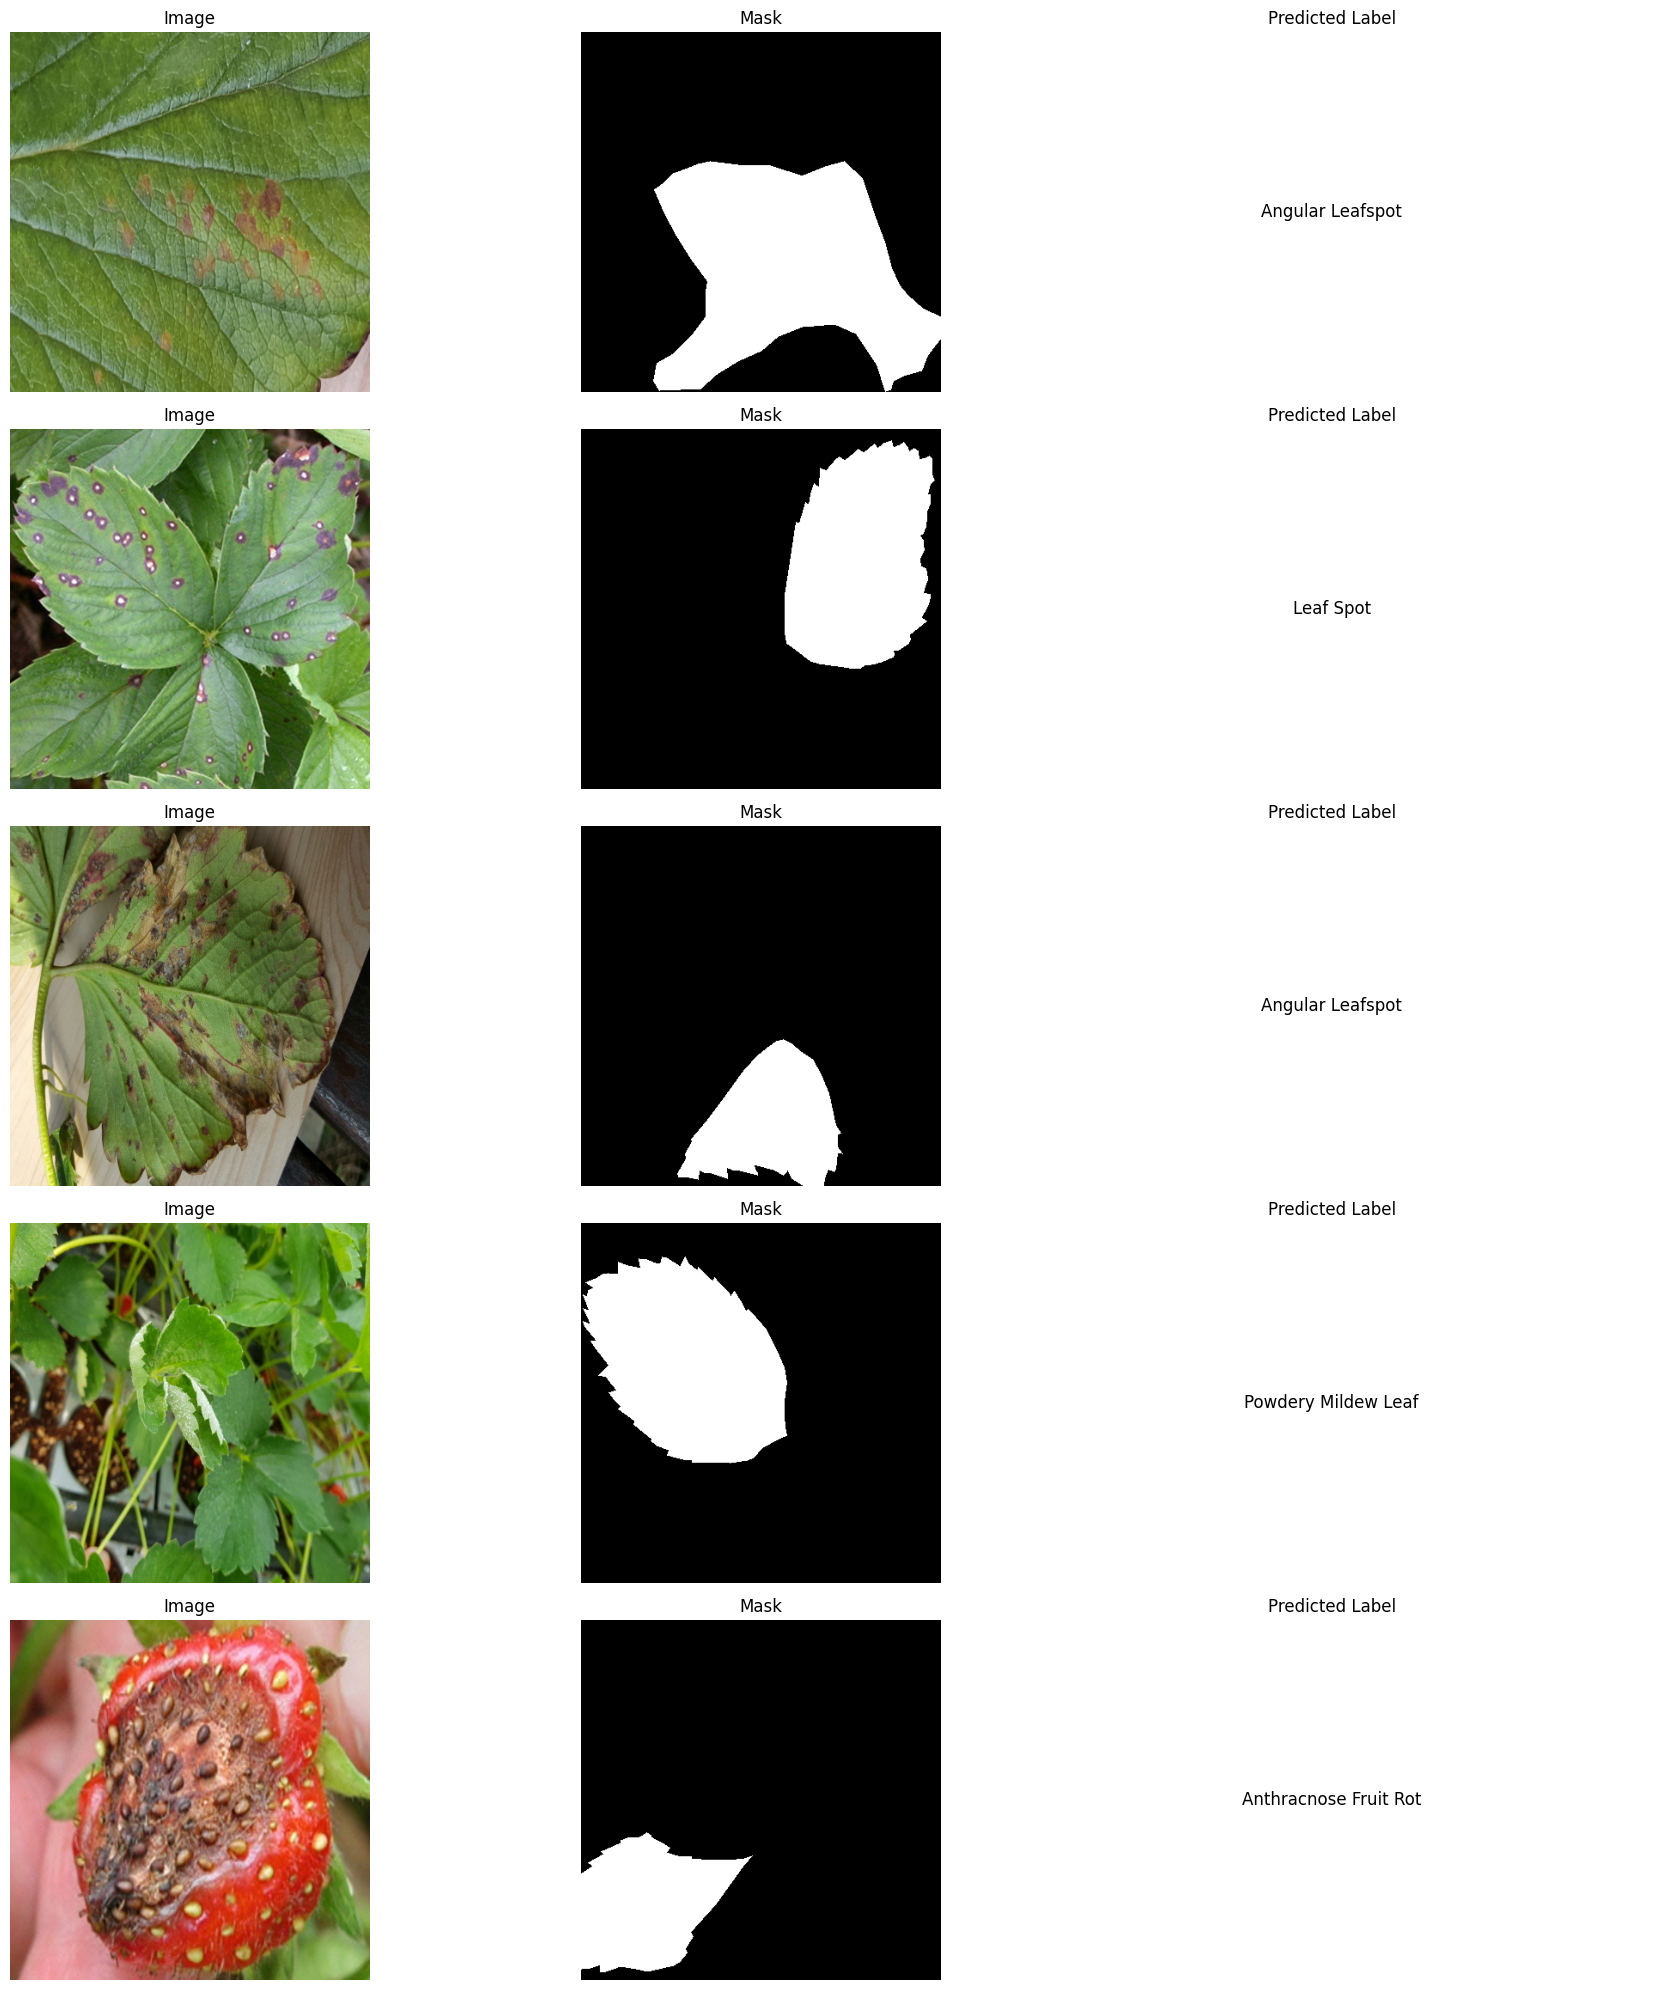

In [ ]:
import json
import glob
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model

# Directory paths
# train_dir = "/content/drive/MyDrive/archive/train"
# test_dir = "/content/drive/MyDrive/archive/test"
# val_dir = "/content/drive/MyDrive/archive/val"
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

# Function to read the JSON file and extract the polygon coordinates and label
def read_polygon_coordinates_and_label_from_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    polygons = data["shapes"]
    coordinates = []
    labels = []
    for polygon in polygons:
        points = polygon["points"]
        points = [coord for sublist in points for coord in sublist]
        label = polygon["label"]
        coordinates.append(points)
        labels.append(label)
    return coordinates, labels

# Generate Mask
def generate_masks(image_size, coordinates):
    masks = []
    for points in coordinates:
        mask = Image.new("L", image_size, 0)
        ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
        masks.append(np.array(mask))
    return masks

# Function to get image paths, masks, and labels
def get_image_paths_masks_and_labels(directory):
    image_paths = []
    masks = []
    labels = []
    for image_path in glob.glob(os.path.join(directory, "*.jpg")):
        json_path = image_path.replace(".jpg", ".json")
        if os.path.exists(json_path):
            coordinates, label = read_polygon_coordinates_and_label_from_json(json_path)
            image = Image.open(image_path)
            image_size = image.size
            image_paths.append(image_path)
            masks.extend(generate_masks(image_size, coordinates))
            labels.append(label)
    return image_paths, masks, labels

# Load and preprocess images
def load_and_preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Get image paths, masks, and labels for train, test, and validation sets
train_image_paths, train_masks, train_labels = get_image_paths_masks_and_labels(train_dir)
test_image_paths, test_masks, test_labels = get_image_paths_masks_and_labels(test_dir)
val_image_paths, val_masks, val_labels = get_image_paths_masks_and_labels(val_dir)

# Convert lists to arrays
train_masks = np.array(train_masks)
test_masks = np.array(test_masks)
val_masks = np.array(val_masks)

# Initialize the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features using ResNet50
def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        img_array = load_and_preprocess_image(image_path)
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

train_features = extract_features(train_image_paths)
test_features = extract_features(test_image_paths)
val_features = extract_features(val_image_paths)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform([label[0] if isinstance(label, list) else label for label in train_labels])
test_labels_encoded = label_encoder.transform([label[0] if isinstance(label, list) else label for label in test_labels])
val_labels_encoded = label_encoder.transform([label[0] if isinstance(label, list) else label for label in val_labels])

# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, train_labels_encoded)

# 0Evaluate the classifier
test_predictions = svm_classifier.predict(test_features)
val_predictions = svm_classifier.predict(val_features)

print("Test Set Classification Report:")
print(classification_report(test_labels_encoded, test_predictions, target_names=label_encoder.classes_))

print("Validation Set Classification Report:")
print(classification_report(val_labels_encoded, val_predictions, target_names=label_encoder.classes_))

# Plot some sample images with predicted labels
num_samples = 5
sample_images = test_image_paths[:num_samples]
sample_masks = test_masks[:num_samples]
sample_labels = test_predictions[:num_samples]

fig, axs = plt.subplots(num_samples, 3, figsize=(18, 4 * num_samples))
for i in range(num_samples):
    image_path = sample_images[i]
    mask = sample_masks[i]
    label = label_encoder.inverse_transform([sample_labels[i]])[0]
    true_label=test_labels
    image = plt.imread(image_path)
    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Image")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis("off")
    axs[i, 2].text(0.5, 0.5, label, ha="center", va="center", fontsize=12)
    axs[i, 2].set_title("Predicted Label")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.savefig("sample_strawberry_disease_predictions.png")
plt.show()


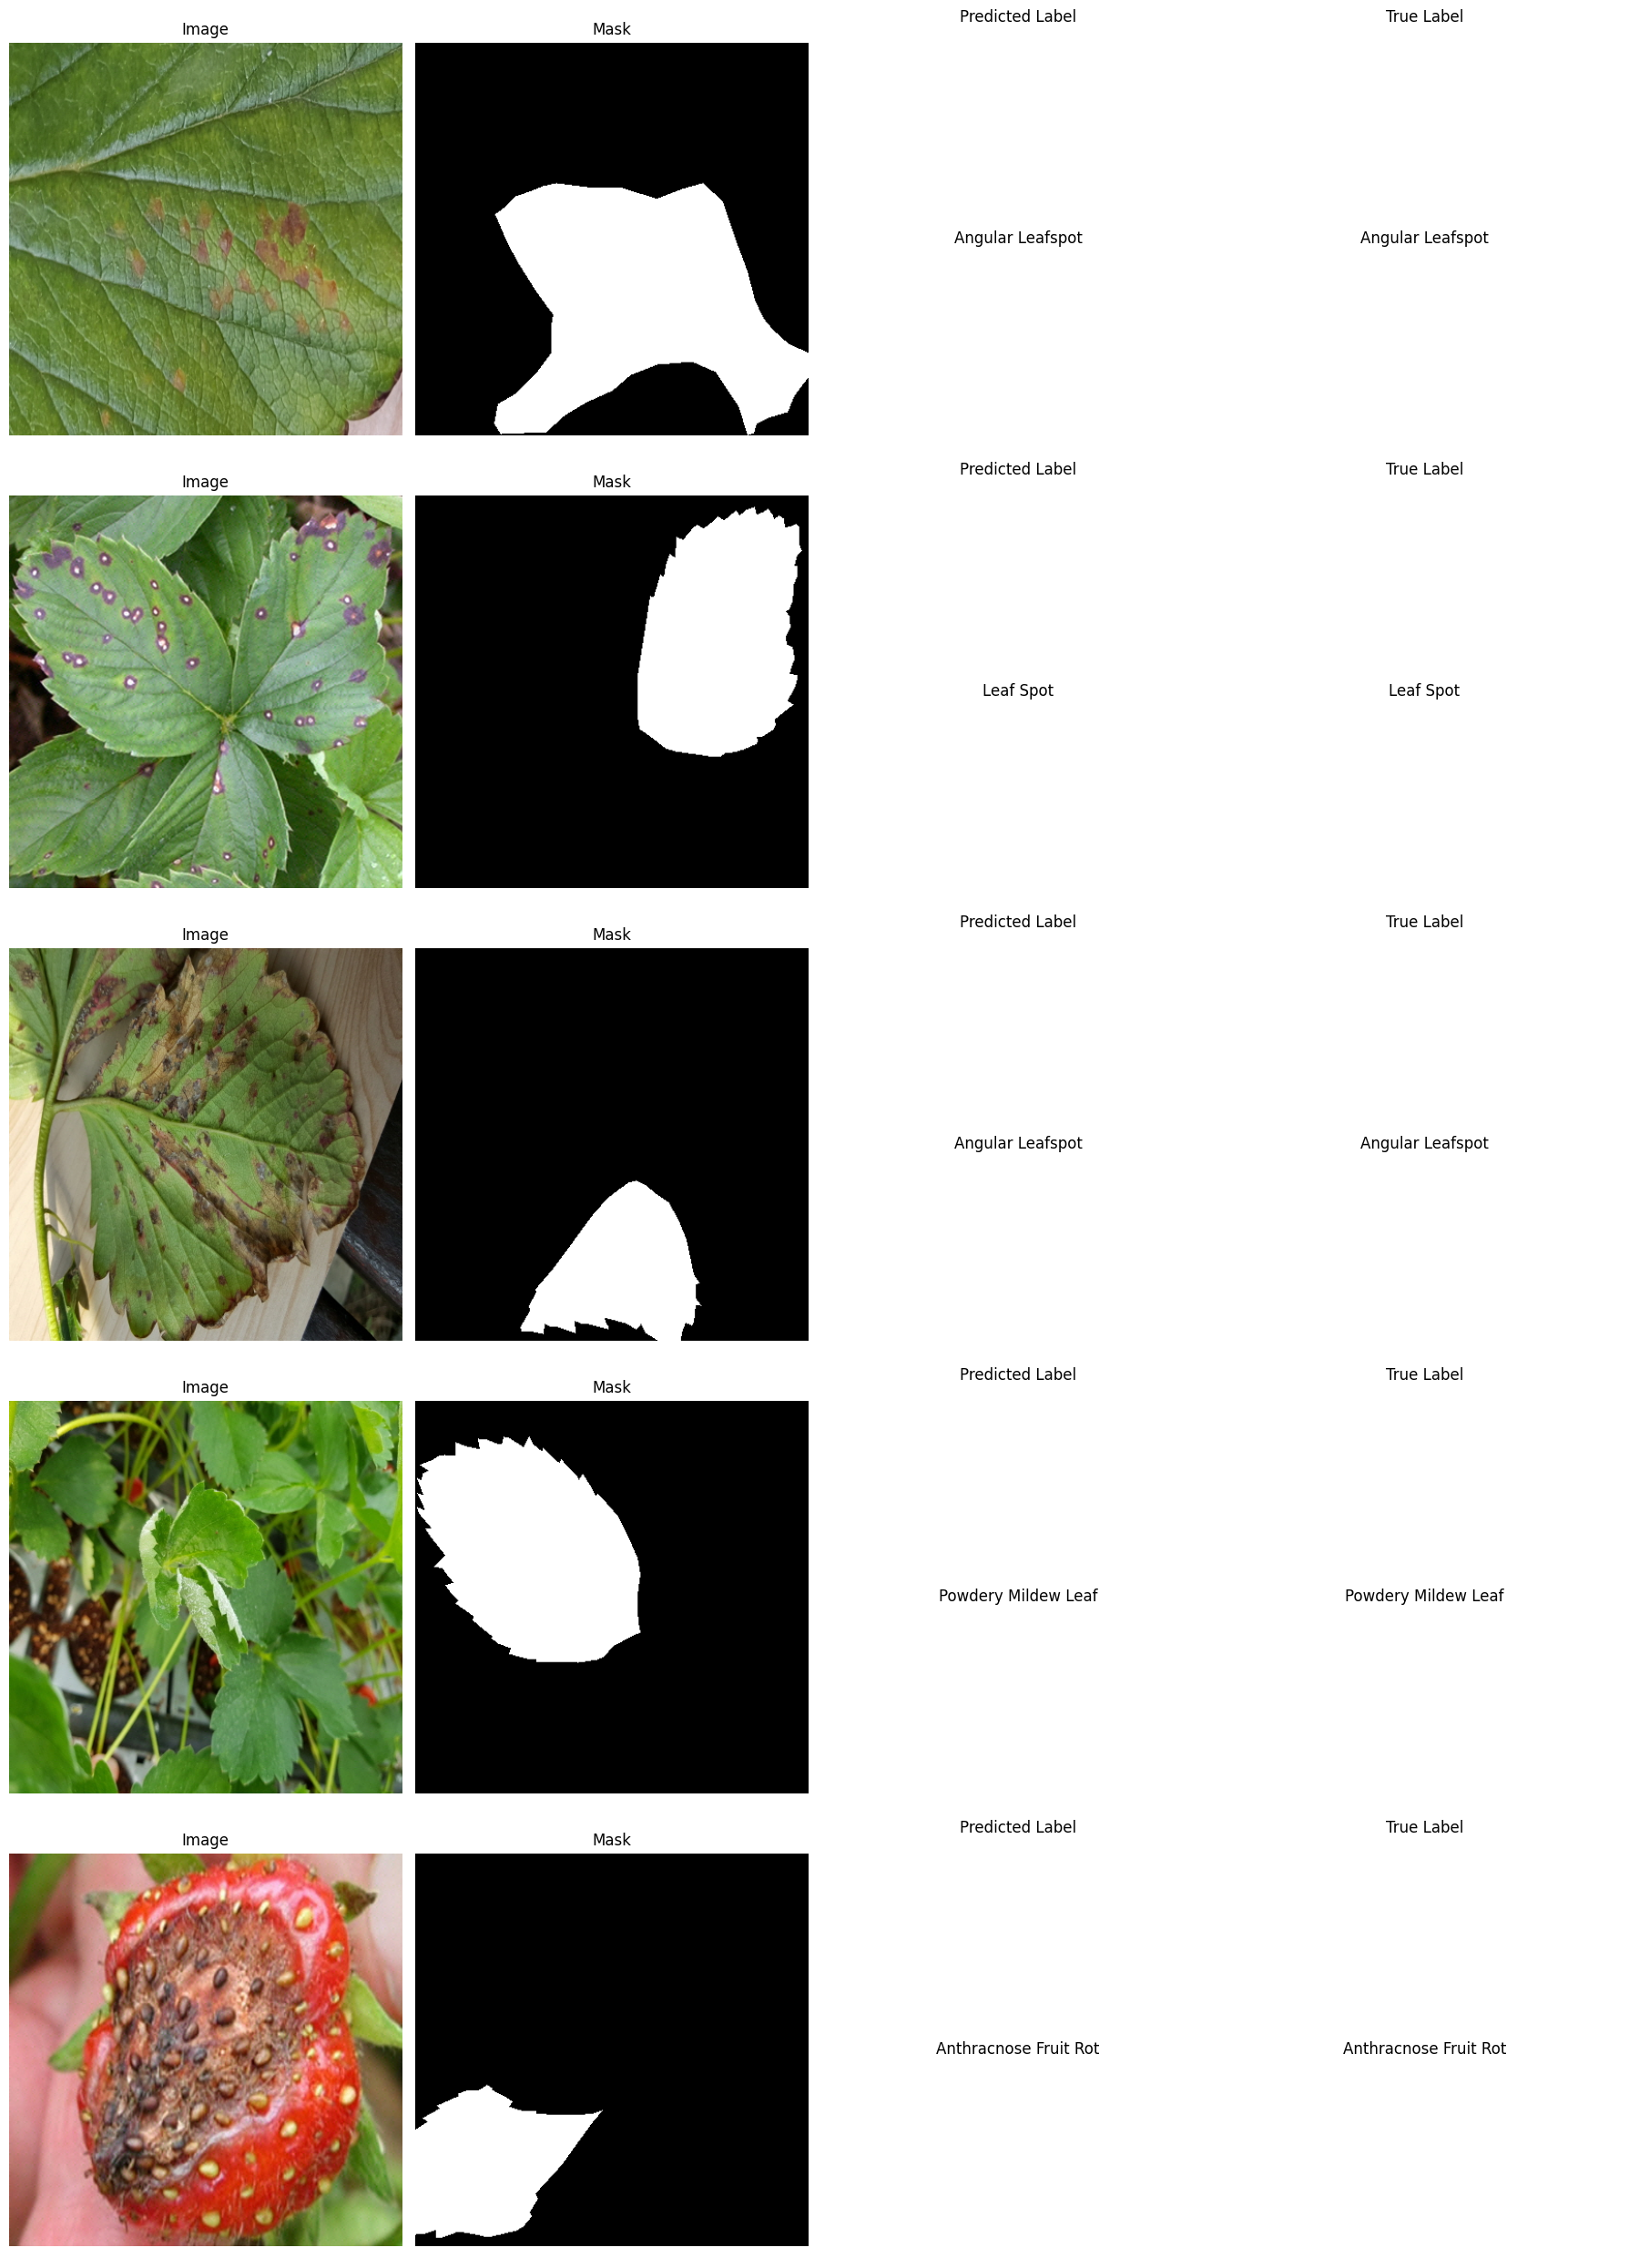

In [ ]:
# Plot some sample images with predicted labels and true labels
num_samples = 5
sample_images = test_image_paths[:num_samples]
sample_masks = test_masks[:num_samples]
sample_pred_labels = test_predictions[:num_samples]
sample_true_labels = test_labels_encoded[:num_samples]

fig, axs = plt.subplots(num_samples, 4, figsize=(18, 5 * num_samples))
for i in range(num_samples):
    image_path = sample_images[i]
    mask = sample_masks[i]
    pred_label = label_encoder.inverse_transform([sample_pred_labels[i]])[0]
    true_label = label_encoder.inverse_transform([sample_true_labels[i]])[0]

    image = plt.imread(image_path)
    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis("off")

    axs[i, 2].text(0.5, 0.5, pred_label, ha="center", va="center", fontsize=12)
    axs[i, 2].set_title("Predicted Label")
    axs[i, 2].axis("off")

    axs[i, 3].text(0.5, 0.5, true_label, ha="center", va="center", fontsize=12)
    axs[i, 3].set_title("True Label")
    axs[i, 3].axis("off")

plt.tight_layout()
plt.savefig("sample_strawberry_disease_predictions.png")
plt.show()


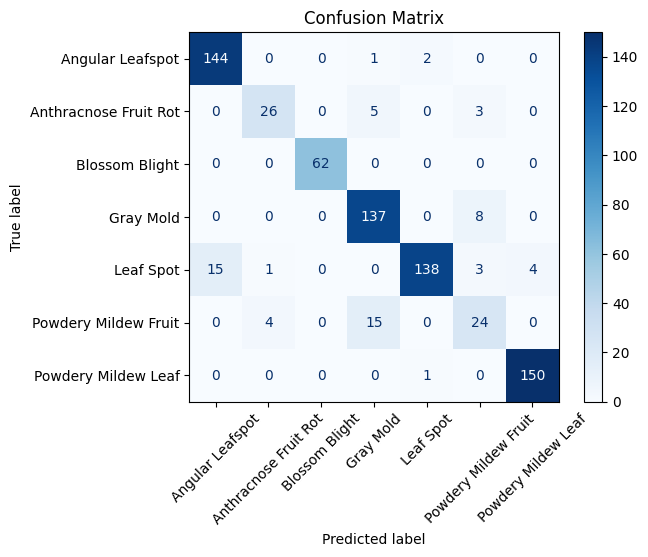

[[144   0   0   1   2   0   0]
 [  0  26   0   5   0   3   0]
 [  0   0  62   0   0   0   0]
 [  0   0   0 137   0   8   0]
 [ 15   1   0   0 138   3   4]
 [  0   4   0  15   0  24   0]
 [  0   0   0   0   1   0 150]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(test_labels_encoded, test_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)

# ax = disp.plot(cmap=plt.cm.Blues)

# Rotate x labels (predicted labels) by 45 degrees
# ax.set_xticks(np.arange(len(label_encoder.classes_)))
# ax.set_xticklabels(label_encoder.classes_, rotation=45, ha="right")

plt.xticks(rotation=45)

plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print(cm)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels_encoded, test_predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(test_labels_encoded, test_predictions, average='weighted')
print(f"Precision: {precision:.2f}")

# Calculate F1 score
f1 = f1_score(test_labels_encoded, test_predictions, average='weighted')
print(f"F1 Score: {f1:.2f}")

# For validation set
val_accuracy = accuracy_score(val_labels_encoded, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

val_precision = precision_score(val_labels_encoded, val_predictions, average='weighted')
print(f"Validation Precision: {val_precision:.2f}")

val_f1 = f1_score(val_labels_encoded, val_predictions, average='weighted')
print(f"Validation F1 Score: {val_f1:.2f}")


Accuracy: 0.92
Precision: 0.92
F1 Score: 0.91
Validation Accuracy: 0.97
Validation Precision: 0.97
Validation F1 Score: 0.97
